# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)
np.random.seed(42)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data import upload_logits

# Utils

In [5]:
T_range = torch.arange(0.01,2.0,0.01)

In [6]:
from itertools import chain
def add_plot_ax(ax,metric,name,color, T_range = T_range, vline_color = 'k', linestyle = '-'):
    if torch.is_tensor(metric):
        metric = metric.cpu()
    if torch.is_tensor(T_range):
        T_range = T_range.cpu()
    beta_star = T_range[np.argmin(metric)]
    ax.plot(T_range,metric, label = name,color=color,linewidth = 2,linestyle=linestyle)
    ax.axvline(beta_star,linestyle = '--', color = vline_color)
    return beta_star

In [7]:
def T_grid(logits,labels,metric,T_range = T_range):
    vals = []
    for T in T_range:
        vals.append(metric(logits.div(T),labels).item())
    return vals

# Evaluate logits

In [8]:
MODEL_ARC = 'vit_h_14'
DATASET = 'ImageNet'

In [9]:
logits,labels = upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                            split = 'test', device = dev)

# Metrics Definition

In [10]:
metrics_dict = {}
metrics_dict['NLL'] = torch.nn.CrossEntropyLoss()
metrics_dict['ECE'] = metrics.ECE(n_bins=15,softmax=True)
metrics_dict['AURC'] = metrics.AURC_fromlogits
metrics_dict['1-AUROC'] = lambda x,y: 1-metrics.AUROC_fromlogits(x,y)

# Metrics Evaluation

In [11]:
metrics_T = {n:T_grid(logits,labels,m,T_range) for n,m in metrics_dict.items()}


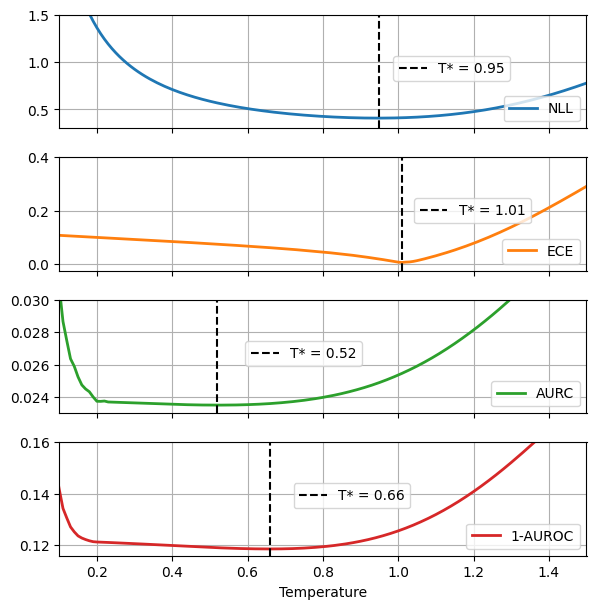

In [47]:
colors = chain(iter(matplotlib.colors.TABLEAU_COLORS.keys()),iter(matplotlib.colors.BASE_COLORS.keys()),iter(matplotlib.colors.TABLEAU_COLORS.keys()))
fig,axes = plt.subplots(len([key for key in metrics_T.keys() if 'Entropy' not in key]),1, figsize = (6,6),sharex = True)
fig.tight_layout()
axes[-1].set_xlabel(r'Temperature')

idx = 0
for name,metric in metrics_T.items():
    color = next(colors)
    linestyle = '-'
    v_color = 'k'
    while color == 'w':
        color = next(colors)

    ax = axes[idx]
    beta_star = add_plot_ax(ax,metric,name, color, vline_color=v_color,linestyle=linestyle)
    legend2 = ax.legend([ax.get_lines()[1]], [fr'T* = {beta_star:.2f}'], loc='upper left',bbox_to_anchor=((1.3*(beta_star/torch.max(T_range)), 0.7)))
    ax.add_artist(legend2)
    idx+=1

for ax in axes:
    ax.grid()
    ax.legend(loc = 'lower right')
    ax.set_xlim(0.1,1.5)

axes[0].set_ylim(0.3,top=1.5)
axes[1].set_ylim(top=0.4)
axes[2].set_ylim(0.023,top=0.03)
axes[3].set_ylim(0.116,top=0.16)

plt.show()